#Tutorial: Recurrent Neural Networks

This turtorial will suplement the paper "Deep Learning Prediction of Polycyclic Aromatic Hydrocarbons in the High Arctic" by Zhao et al. (2019) and will focus on recurrent neural networks (RNN). Through the utilization of bioinformatic tools and techniques, the field of environmental biology has made strides in the analysis of data related to climate change and the health of our planet. With the success of similar research in mind, a proposed idea is to utilize  recurrent neural networks as a means to predict future temperatures in response to concentration of greenhouse gasses in the atmosphere. For this tutorial, a simple time-series dataset pertaining to temperature will be used.

#Importing Example Data 

Zhao et al. (2019)  used a combination of temporal data spanning over many years in the attmept to predict PHE concentration in the atmosphere. The below dataset is similar in that it contains time series data, though this data includes the  daily temperature over a span of years. This dataset will be used in the attmept to create an RNN model to predict temperature. This first step is importating the dataset and determining which columns will be used. In this case, the data will be pulled and read into this colab from a url given to the built-in 'read_csv' function.

In [ ]:
import pandas as pd
#reads in the dataset and uses only the first column
#the data was pulled from https://machinelearningmastery.com/time-series-datasets-for-machine-learning/, authored by Jason Brownlee
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", usecols=[1])


The plot below shows the time-series data. 

Text(0, 0.5, 'Temperature')

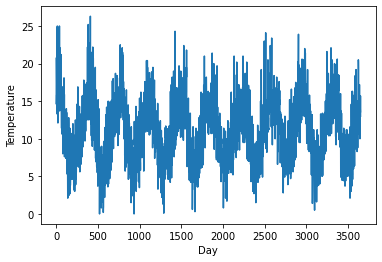

In [ ]:
import matplotlib.pyplot as pl
#plots the data
pl.plot(df)
#labels the plot axis
pl.xlabel('Day')
pl.ylabel('Temperature')

#Standardizing and reshaping the data 

Before the dataset can be used in an RNN, it needs to be split into sets for specified uses (testing/training) and formatted in a way that is readable as input to the model. 

###Standardizing the data

Standardization is used to create consistency and is needed when data has differing scales. If ever unsure on whether to standardize (or perhaps normalize) data, it is better to do so than not. In this tutorial, an example of stadardization will be shown through using the 'MinMaxScaler" from sklearn. This will transform the data to values within a given range, in this case the range will be 0-1.

In [ ]:
'''
The code in the following cells is supplemented from the subsequent resources: 
"How to use RMSE as loss function in Keras with code examples" ({https://www.folkstalk.com/2022/10/how-to-use-rmse-as-loss-function-in-keras-with-code-examples.html), 
"Understanding simple recurrent neural networks in Keras" (https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/),
"Sklearn.preprocessing.MinMaxScaler" (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).
'''
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#putting the data into an array using numpy
data_array = np.array(df)
#using MinMaxScaler to standardize the data.. values will be between 0 and 1 when the "standardized" variable is used
standardize = MinMaxScaler(feature_range=(0,1))
#the data is transformed using standardization 
data = standardize.fit_transform(data_array)
#data array is flattened into 1D array
flat_data = data.flatten()

###Generating the testing and training data

The dataset will be split into 2 categories: testing and training data. The training set will be comprised of 80% of the total data and the remaining 20% will be allocated to testing. 

In [ ]:
#finding how many data points there are in order to determine what 80%/20% of the data will be
num_data_points = len(flat_data)
#number of data points that show be used for training
train_number = num_data_points * .8
#the first 80% of the data will be used for training (includes indeces from 0-train_number)
training_data = flat_data[0:int(train_number)]
#the last 20% of the data will be used for testing (includes indeces from train_number-the end)
testing_data = flat_data[int(train_number):]

Reshaping the training data  

In [ ]:
#determining the target indices
#91 is used as the time step.. every 91 days the temperature cycle changes 
train_target_indices = np.arange(91, len(training_data), 91)
#from the training data, training_y will be the data points at the target indices
training_y = training_data[train_target_indices]
training_x = training_data[range(91*len(training_y))]
#reshaping the data into a format acceptable 
training_x = np.reshape(training_x, (len(training_y), 91, 1))  

Reshaping the testing data 

In [ ]:
#determining the testing target indices
test_target_indices = np.arange(91, len(testing_data), 91)
#from the testing data, testing_y will be the data points at the testing target indices
testing_y = testing_data[test_target_indices]
testing_x = testing_data[range(91*len(testing_y))]
#reshaping the data 
testing_x = np.reshape(testing_x, (len(testing_y), 91, 1))  

##Putting together the RNN Model 

When creating a RNN model, there is no one set requirement for the number of layers to add, nor is there a requirment for the parameters of each layer. For example, Zhao et al. (2019) used a model consisting of 7 layers. Layers 1-6 were LSTM layers followed by a dense 7th layer. Each LSTM Layer had 256 units, and there were a total of 7,113,985 parameters in the model. Though those specifications worked for their study, it is important to tune parameters in accomidation to your specific dataset. For this tutorial, the below model will show three LSTM layers followed by a dense layer. This example model will therefore have far less parameters for training and will be able to be executed in a timely manner.

In [ ]:
#Some functions are not always built in. For example, RMSE is not a built-in metric for loss, though it can be custom built if its utilization is desired.
#code was referenced from "folkstalk.com"
from keras import backend as k
def RMSE(observed, predicted):
        return k.sqrt(k.mean(k.square(predicted - observed), axis=-1)) 
#RMSE could then be used in the complie function. Ex. model.compile(loss ='RMSE', optimizer='adam')

'''
Ex) To create a model with many LSTM layers, as would have been done by Zhao et al. (2019) and other studies off similar stature, the following pattern could be implemented:     

model = keras.Sequential()
model.add(LSTM(units, return_sequences=True, input_shape=(timesteps,features/dimensions)))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=True))
...
model.add(LSTM(units))
model.add(Dense(units))

Explanation:
Sequential() - allows the model to be constructed layer by layer 
LSTM - allows the model to learn dependencies between timesteps in the time-series dataset 
Then last layer added after the LSTM layers is a fully connected 'Dense' layer 

'''
#imports needed to create the RNN model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

#making the model
model = keras.Sequential()
#adds first LSTM layer.. returns for next layer, input shape represents timestep (91) and feature count (1)
model.add(LSTM(3, return_sequences=True, input_shape=(91,1)))
#adds second LSTM layer.. returns for next layer
model.add(LSTM(2, return_sequences=True))
#adds third LSTM layer 
model.add(LSTM(1))
#adds dense layer
model.add(Dense(1))
#compiles the model
##hyperparameters loss function (MAE) and optimizer(Adam) are utilized 
model.compile(loss ='mean_absolute_error', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 91, 3)             60        
                                                                 
 lstm_19 (LSTM)              (None, 91, 2)             48        
                                                                 
 lstm_20 (LSTM)              (None, 1)                 16        
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


Call fit method to perform training 

In [ ]:
#fits the model.. iterates 150 times and shows the loss  
model.fit(training_x, training_y, epochs=150, batch_size=1, verbose=1)

Epoch 1/150
32/32 [==============================] - 6s 52ms/step - loss: 0.3322
Epoch 2/150
32/32 [==============================] - 2s 51ms/step - loss: 0.2217
Epoch 3/150
32/32 [==============================] - 2s 51ms/step - loss: 0.1567
Epoch 4/150
32/32 [==============================] - 2s 74ms/step - loss: 0.1359
Epoch 5/150
32/32 [==============================] - 2s 56ms/step - loss: 0.1259
Epoch 6/150
32/32 [==============================] - 2s 50ms/step - loss: 0.1241
Epoch 7/150
32/32 [==============================] - 2s 49ms/step - loss: 0.1237
Epoch 8/150
32/32 [==============================] - 2s 50ms/step - loss: 0.1223
Epoch 9/150
32/32 [==============================] - 2s 51ms/step - loss: 0.1206
Epoch 10/150
32/32 [==============================] - 2s 51ms/step - loss: 0.1206
Epoch 11/150
32/32 [==============================] - 2s 56ms/step - loss: 0.1177
Epoch 12/150
32/32 [==============================] - 2s 52ms/step - loss: 0.1149
Epoch 13/150
32/32 [=====

Using the model to make predictions 

In [ ]:
import tensorflow as tf
#using the built in "predict" frunction to make predictions 
predictions_train = model.predict(training_x)
predicitons_test = model.predict(testing_x)

1/1 [==============================] - 0s 29ms/step


#Evalutating the model 
There are multiple means by which a model can be evaluated, below will present mean absolute error (MAE), root mean square error (RMSE), mean absolute percentage error (MAPE) and coefficient of determination $R^{2}$. 

*italicized text*###**MAE**

A MAE close to 0 indicates greater accuracy. 

In [ ]:
from sklearn.metrics import mean_absolute_error

#calculating the MAE of the training data
mae_train = (mean_absolute_error(training_y,predictions_train))
#calculating the MAE of the testing data 
mae_test = (mean_absolute_error(testing_y,predicitons_test))
print("MAPE of training data: " + str(mae_train))
print("MAPE of testing data: " + str(mae_test))


MAPE of training data: 0.07442785540645226
MAPE of testing data: 0.032635773528551425


###**RMSE**

A lower RMSE indicates a better fit. 

In [ ]:
import math
from sklearn.metrics import mean_squared_error

#calculating the rmse of the training data.. uses built in math function along with the built in MSE function from sklearn
rmse_train = math.sqrt(mean_squared_error(training_y,predictions_train))
#calculating the RMSE of the testing data
rmse_test = math.sqrt(mean_squared_error(testing_y,predicitons_test))

print("RMSE of training data: " + str(rmse_train))
print("RMSE of testing data: " + str(rmse_test))

RMSE of training data: 0.09015962857483467
RMSE of testing data: 0.037410332436601614


###**MAPE**

The lower the MAPE, the more accurate the model. 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

#calculating MAPE of the training data
mape_train = (mean_absolute_percentage_error(training_y,predictions_train))
#calculating MAPE of the testing data
mape_test = (mean_absolute_percentage_error(testing_y,predicitons_test))

print("MAPE of training data: " + str(mape_train))
print("MAPE of testing data: " + str(mape_test))

MAPE of training data: 0.19226078935410856
MAPE of testing data: 0.07688012038800657


###**Coefficient of determination $R^{2}$**

A higher coefficient of determination indicates better fit. 

In [ ]:
from sklearn.metrics import r2_score

#calculating R^2 of the training data
r_train = r2_score(training_y,predictions_train)
#calculating R^2 of the testing data
r_test = r2_score(testing_y,predicitons_test)

print("R^2 of training data: " + str(r_train))
print("R^2 of testing data: " + str(r_test))

R^2 of training data: 0.6227956318218013
R^2 of testing data: 0.9094175835212669


###Visualizing MAE, RMSE, and MAPE scores

To keep visualization consistant, coefficient of determination $R^{2}$ is not included since, unlike the other metrics of evalution, a low $R^{2}$ score indicates poor fit. For MAE, RMSE, and MAPE low scores indicates better performance. 

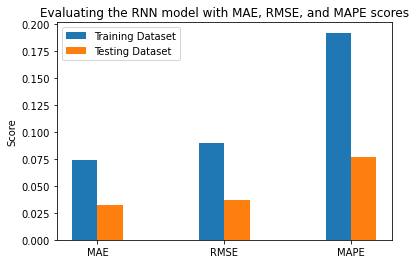

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#setting what will be the bar lables 
x_labels = ['MAE', 'RMSE', 'MAPE']
#suppling the data 
training_scores = [mae_train, rmse_train, mape_train]
testing_scores = [mae_test, rmse_test, mape_test]
x = np.arange(len(x_labels)) 
#creating the mulitple bars.. x-.1/x+.1 sets how close the bars will be...  .2 sets the width of the bars
plt.bar(x - .1, training_scores, .2, label = 'Training Dataset')
plt.bar(x + .1, testing_scores, .2, label = 'Testing Dataset')
#arranges the labels on the x axis from the x_labels array
plt.xticks(x, x_labels)
plt.ylabel("Score")
plt.title("Evaluating the RNN model with MAE, RMSE, and MAPE scores")
plt.legend()
plt.show()



##Plotting the results

One way to present results is by plotting the RNN predicted values in comparison to the observed values. Below shows an example implementation of plotting such results. 

Text(0.5, 1.0, 'RNN prediction of temperature vs observed temperature ')

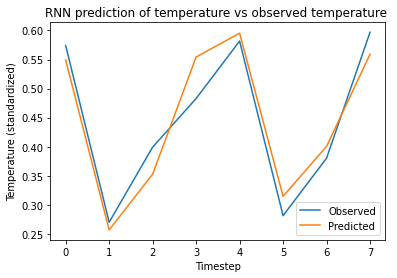

In [ ]:
import matplotlib.pyplot as p
#assigning the data to variables for readability 
observed = testing_y
predictions = predicitons_test
#plotting the observed data
p.plot(observed)
#plotting the predicted data 
p.plot(predictions)
#Labeling the plot
p.legend(['Observed', 'Predicted'])
p.xlabel('Timestep')
p.ylabel('Temperature (standardized)')
p.title('RNN prediction of temperature vs observed temperature ')
